In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
Step 2: Autoencoder Training
=============================
Trains a separate autoencoder per exercise on the extracted angle data.
The autoencoder learns what good form looks like. At inference time,
reconstruction error = how far the user deviates from good form.
The decoder output = the corrective "ideal" pose.

Author: You (guided by Claude)
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

In [3]:


# ── Reproducibility ────────────────────────────────────────────────────────────
np.random.seed(42)
tf.random.set_seed(42)

# ── Config ─────────────────────────────────────────────────────────────────────
CSV_PATH    = "angles.csv"
OUTPUT_DIR  = "models"          # Saved models and scalers go here
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Features used per exercise — must match what extract_landmarks.py produces
EXERCISE_FEATURES = {
    "squat": [
        "left_knee_angle",
        "right_knee_angle",
        "left_hip_angle",
        "right_hip_angle",
        "torso_lean",
        "left_knee_valgus",
        "right_knee_valgus",
        "hip_depth_left",
        "hip_depth_right",
        "left_ankle_angle",
        "right_ankle_angle",
    ],
    "lateral raise": [
        "left_arm_raise",
        "right_arm_raise",
        "left_elbow_angle",
        "right_elbow_angle",
        "torso_lean",
        "arm_symmetry",
        "left_wrist_above_shoulder",
        "right_wrist_above_shoulder",
    ],
}


In [4]:


# ══════════════════════════════════════════════════════════════════════════════
# DATA LOADING & PREPROCESSING
# ══════════════════════════════════════════════════════════════════════════════

def load_exercise_data(csv_path, exercise):
    """
    Load and preprocess data for a single exercise.

    Returns:
        X_train, X_val  — normalised numpy arrays
        scaler          — fitted StandardScaler (saved for inference)
        feature_cols    — list of feature column names
    """
    df = pd.read_csv(csv_path)
    df = df[df["exercise"] == exercise].copy()

    print(f"\n[{exercise.upper()}]")
    print(f"  Raw rows: {len(df)}")

    feature_cols = EXERCISE_FEATURES[exercise]

    # Drop rows with any NaN in our feature columns
    df = df[feature_cols].dropna()
    print(f"  After dropping NaN rows: {len(df)}")

    if len(df) < 50:
        raise ValueError(f"Not enough data for {exercise} — only {len(df)} rows after cleaning.")

    X = df[feature_cols].values.astype(np.float32)

    # Normalise — autoencoders are sensitive to scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train / validation split (80/20)
    X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

    print(f"  Train samples: {len(X_train)}")
    print(f"  Val samples:   {len(X_val)}")
    print(f"  Features ({len(feature_cols)}): {feature_cols}")

    return X_train, X_val, scaler, feature_cols

In [5]:



# ══════════════════════════════════════════════════════════════════════════════
# AUTOENCODER ARCHITECTURE
# ══════════════════════════════════════════════════════════════════════════════

def build_autoencoder(input_dim, latent_dim=4):
    """
    Build a symmetric autoencoder.

    Architecture:
        Encoder: input_dim → 32 → 16 → latent_dim
        Decoder: latent_dim → 16 → 32 → input_dim

    The latent space compresses the pose into its essential "form fingerprint".
    The decoder reconstructs the ideal pose from that fingerprint.

    Args:
        input_dim:  Number of angle features
        latent_dim: Size of the bottleneck (smaller = more compression)

    Returns:
        autoencoder, encoder, decoder  (all as Keras models)
    """

    # ── Encoder ───────────────────────────────────────────────────────────────
    encoder_input = keras.Input(shape=(input_dim,), name="encoder_input")
    x = layers.Dense(32, activation="relu", name="enc_dense_1")(encoder_input)
    x = layers.BatchNormalization(name="enc_bn_1")(x)
    x = layers.Dense(16, activation="relu", name="enc_dense_2")(x)
    x = layers.BatchNormalization(name="enc_bn_2")(x)
    latent = layers.Dense(latent_dim, activation="linear", name="latent")(x)

    encoder = keras.Model(encoder_input, latent, name="encoder")

    # ── Decoder ───────────────────────────────────────────────────────────────
    decoder_input = keras.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(16, activation="relu", name="dec_dense_1")(decoder_input)
    x = layers.BatchNormalization(name="dec_bn_1")(x)
    x = layers.Dense(32, activation="relu", name="dec_dense_2")(x)
    x = layers.BatchNormalization(name="dec_bn_2")(x)
    decoder_output = layers.Dense(input_dim, activation="linear", name="decoder_output")(x)

    decoder = keras.Model(decoder_input, decoder_output, name="decoder")

    # ── Full autoencoder ──────────────────────────────────────────────────────
    autoencoder_input = keras.Input(shape=(input_dim,), name="autoencoder_input")
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)

    autoencoder = keras.Model(autoencoder_input, decoded, name="autoencoder")

    return autoencoder, encoder, decoder

In [6]:



# ══════════════════════════════════════════════════════════════════════════════
# TRAINING
# ══════════════════════════════════════════════════════════════════════════════

def train_autoencoder(X_train, X_val, input_dim, exercise_name, latent_dim=4):
    """
    Compile and train the autoencoder.

    Returns:
        autoencoder, encoder, decoder, history
    """
    autoencoder, encoder, decoder = build_autoencoder(input_dim, latent_dim)

    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",         # Mean squared error — measures reconstruction quality
        metrics=["mae"],    # Mean absolute error — easier to interpret
    )

    autoencoder.summary()

    callbacks = [
        # Stop early if validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=20,
            restore_best_weights=True,
            verbose=1,
        ),
        # Reduce learning rate when stuck
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1,
        ),
    ]

    print(f"\nTraining autoencoder for: {exercise_name}")

    history = autoencoder.fit(
        X_train, X_train,       # Input = Target (autoencoder reconstructs its input)
        validation_data=(X_val, X_val),
        epochs=300,
        batch_size=32,
        callbacks=callbacks,
        verbose=1,
    )

    return autoencoder, encoder, decoder, history

In [7]:



# ══════════════════════════════════════════════════════════════════════════════
# EVALUATION & THRESHOLD SETTING
# ══════════════════════════════════════════════════════════════════════════════

def evaluate_and_set_threshold(autoencoder, X_val, exercise_name, percentile=95):
    """
    Compute reconstruction errors on validation data and set a threshold.

    The threshold defines what counts as "bad form" at inference time.
    We use the Nth percentile of good-form errors, so anything above it
    is considered a meaningful deviation.

    Returns:
        threshold (float)
    """
    reconstructions = autoencoder.predict(X_val, verbose=0)
    errors = np.mean(np.square(X_val - reconstructions), axis=1)  # Per-sample MSE

    threshold = float(np.percentile(errors, percentile))

    print(f"\n[{exercise_name.upper()}] Reconstruction Error Stats (validation set):")
    print(f"  Mean:       {errors.mean():.4f}")
    print(f"  Std:        {errors.std():.4f}")
    print(f"  Min:        {errors.min():.4f}")
    print(f"  Max:        {errors.max():.4f}")
    print(f"  Threshold ({percentile}th percentile): {threshold:.4f}")
    print(f"  → Errors above {threshold:.4f} will be flagged as bad form")

    return threshold, errors


def plot_training_history(history, exercise_name, output_dir):
    """Plot training and validation loss curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history["loss"],     label="Train loss")
    axes[0].plot(history.history["val_loss"], label="Val loss")
    axes[0].set_title(f"{exercise_name} — Loss (MSE)")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(history.history["mae"],     label="Train MAE")
    axes[1].plot(history.history["val_mae"], label="Val MAE")
    axes[1].set_title(f"{exercise_name} — MAE")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    plt.tight_layout()
    path = os.path.join(output_dir, f"{exercise_name.replace(' ', '_')}_training.png")
    plt.savefig(path)
    plt.show()
    print(f"  Training curve saved to: {path}")


def plot_error_distribution(errors, threshold, exercise_name, output_dir):
    """Plot the reconstruction error distribution and threshold."""
    plt.figure(figsize=(8, 4))
    plt.hist(errors, bins=30, edgecolor="black", alpha=0.7, color="steelblue")
    plt.axvline(threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold: {threshold:.4f}")
    plt.title(f"{exercise_name} — Reconstruction Error Distribution (validation set)")
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    path = os.path.join(output_dir, f"{exercise_name.replace(' ', '_')}_errors.png")
    plt.savefig(path)
    plt.show()
    print(f"  Error distribution saved to: {path}")


In [8]:

# ══════════════════════════════════════════════════════════════════════════════
# SAVING
# ══════════════════════════════════════════════════════════════════════════════

def save_model_artifacts(autoencoder, encoder, decoder, scaler,
                          feature_cols, threshold, exercise_name, output_dir):
    """
    Save everything needed for inference:
      - autoencoder weights
      - encoder and decoder separately (for inference)
      - scaler (to normalise incoming webcam data the same way)
      - metadata (feature list, threshold)
    """
    safe_name = exercise_name.replace(" ", "_")

    # Save full models
    autoencoder.save(os.path.join(output_dir, f"{safe_name}_autoencoder.keras"))
    encoder.save(os.path.join(output_dir,     f"{safe_name}_encoder.keras"))
    decoder.save(os.path.join(output_dir,     f"{safe_name}_decoder.keras"))

    # Save scaler
    with open(os.path.join(output_dir, f"{safe_name}_scaler.pkl"), "wb") as f:
        pickle.dump(scaler, f)

    # Save metadata
    meta = {
        "exercise":     exercise_name,
        "features":     feature_cols,
        "threshold":    threshold,
        "input_dim":    len(feature_cols),
        "latent_dim":   4,
    }
    with open(os.path.join(output_dir, f"{safe_name}_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(f"\n  Saved to: {output_dir}/")
    print(f"    {safe_name}_autoencoder.keras")
    print(f"    {safe_name}_encoder.keras")
    print(f"    {safe_name}_decoder.keras")
    print(f"    {safe_name}_scaler.pkl")
    print(f"    {safe_name}_meta.json")

In [9]:



# ══════════════════════════════════════════════════════════════════════════════
# MAIN
# ══════════════════════════════════════════════════════════════════════════════

def train_all(csv_path=CSV_PATH, output_dir=OUTPUT_DIR, latent_dim=4):
    """Train an autoencoder for each exercise in the CSV."""

    results = {}

    for exercise in EXERCISE_FEATURES.keys():
        print("\n" + "="*60)
        print(f"EXERCISE: {exercise.upper()}")
        print("="*60)

        # 1. Load data
        try:
            X_train, X_val, scaler, feature_cols = load_exercise_data(csv_path, exercise)
        except ValueError as e:
            print(f"  [SKIP] {e}")
            continue

        input_dim = len(feature_cols)

        # 2. Train
        autoencoder, encoder, decoder, history = train_autoencoder(
            X_train, X_val, input_dim, exercise, latent_dim=latent_dim
        )

        # 3. Evaluate & set threshold
        threshold, errors = evaluate_and_set_threshold(autoencoder, X_val, exercise)

        # 4. Plot
        plot_training_history(history, exercise, output_dir)
        plot_error_distribution(errors, threshold, exercise, output_dir)

        # 5. Save
        save_model_artifacts(
            autoencoder, encoder, decoder, scaler,
            feature_cols, threshold, exercise, output_dir
        )

        results[exercise] = {
            "threshold": threshold,
            "val_samples": len(X_val),
        }

    print("\n" + "="*60)
    print("ALL DONE")
    print("="*60)
    for ex, r in results.items():
        print(f"  {ex}: threshold={r['threshold']:.4f}, val_samples={r['val_samples']}")

    return results


EXERCISE: SQUAT

[SQUAT]
  Raw rows: 1323
  After dropping NaN rows: 1323
  Train samples: 1058
  Val samples:   265
  Features (11): ['left_knee_angle', 'right_knee_angle', 'left_hip_angle', 'right_hip_angle', 'torso_lean', 'left_knee_valgus', 'right_knee_valgus', 'hip_depth_left', 'hip_depth_right', 'left_ankle_angle', 'right_ankle_angle']


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 11)]              0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 4)                 1172      
                                                                 
 decoder (Functional)        (None, 11)                1179      
                                                                 
Total params: 2351 (9.18 KB)
Trainable params: 2159 (8.43 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________

Training autoencoder for: squat
Epoch 1/300
34/34 [==============================] - 1s 5ms/step - loss: 1.5615 - mae: 0.9709 - val_loss: 0.9917 - val_mae: 0.7560 - lr: 0.0010
Epoch 2/300
34/34 [=====================

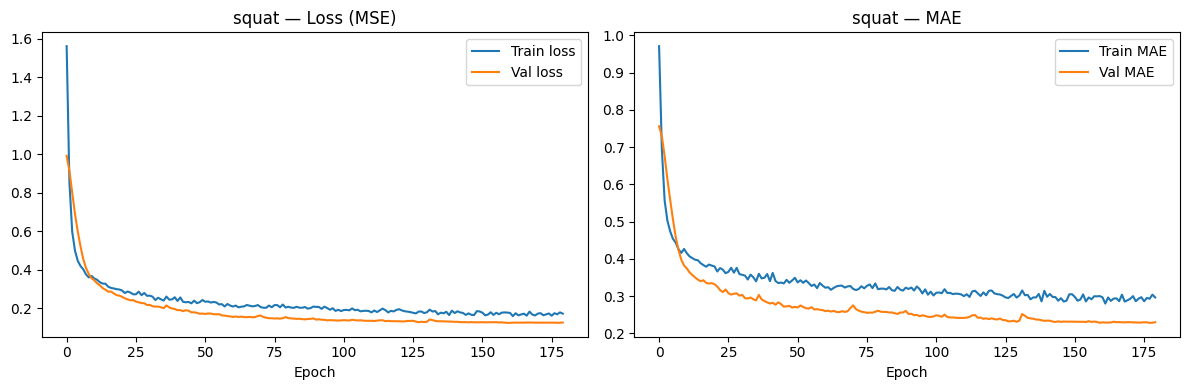

  Training curve saved to: models/squat_training.png


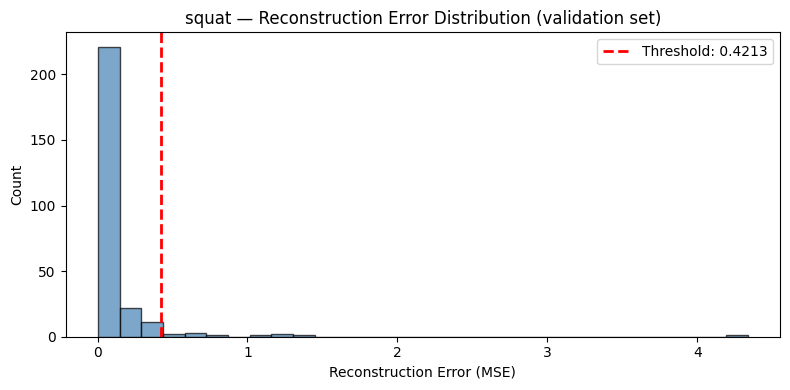

  Error distribution saved to: models/squat_errors.png

  Saved to: models/
    squat_autoencoder.keras
    squat_encoder.keras
    squat_decoder.keras
    squat_scaler.pkl
    squat_meta.json

EXERCISE: LATERAL RAISE

[LATERAL RAISE]
  Raw rows: 1275
  After dropping NaN rows: 1275
  Train samples: 1020
  Val samples:   255
  Features (8): ['left_arm_raise', 'right_arm_raise', 'left_elbow_angle', 'right_elbow_angle', 'torso_lean', 'arm_symmetry', 'left_wrist_above_shoulder', 'right_wrist_above_shoulder']


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 8)]               0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 4)                 1076      
                                                                 
 decoder (Functional)        (None, 8)                 1080      
                                                                 
Total params: 2156 (8.42 KB)
Trainable params: 1964 (7.67 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________

Training autoencoder for: lateral raise
Epoch 1/300
32/32 [==============================] - 1s 7ms/step - loss: 1.5733 - mae: 0.9720 - val_loss: 0.9118 - val_mae: 0.7837 - lr: 0.0010
Epoch 2/300
32/32 [=============

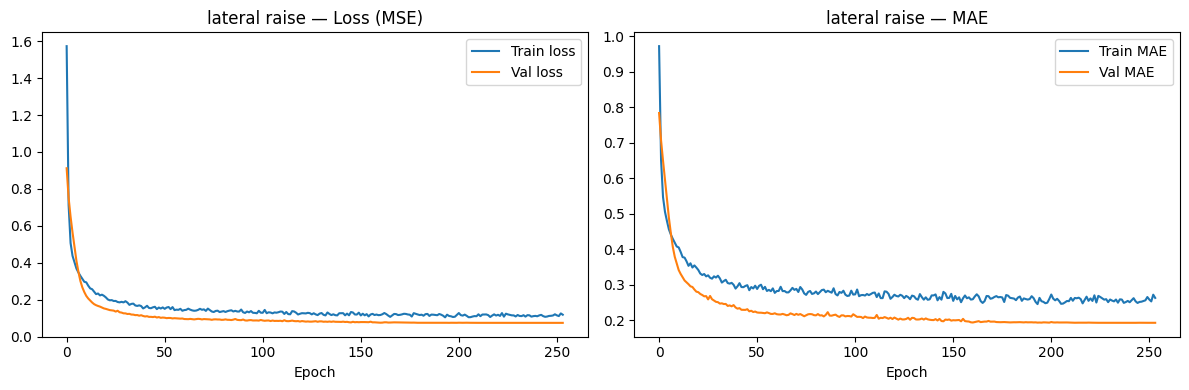

  Training curve saved to: models/lateral_raise_training.png


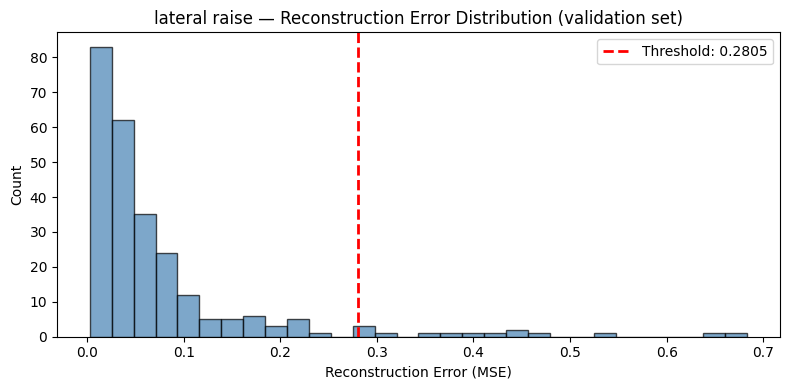

  Error distribution saved to: models/lateral_raise_errors.png

  Saved to: models/
    lateral_raise_autoencoder.keras
    lateral_raise_encoder.keras
    lateral_raise_decoder.keras
    lateral_raise_scaler.pkl
    lateral_raise_meta.json

ALL DONE
  squat: threshold=0.4213, val_samples=265
  lateral raise: threshold=0.2805, val_samples=255


{'squat': {'threshold': 0.42127539515495294, 'val_samples': 265},
 'lateral raise': {'threshold': 0.28052808344364155, 'val_samples': 255}}

In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# ENTRY POINT
# ══════════════════════════════════════════════════════════════════════════════

train_all(
    csv_path="angles.csv",
    output_dir="models",
    latent_dim=4,
)
